PREDICTING CUSTOMER LOAN DEFAULT RISK USING BEHAVIOURAL DATA

In [1]:
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib


In [2]:
#LOADING DATA
df = pd.read_csv(r"c:\Users\DELL\Downloads\archive (2)\loan.csv")   
print("Data loaded successfully!")
print(df.head())


C:\Users\DELL\AppData\Local\Temp\ipykernel_19480\3319155717.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"c:\Users\DELL\Downloads\archive (2)\loan.csv")


Data loaded successfully!
   id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN       2500         2500           2500.0   36 months   
1 NaN        NaN      30000        30000          30000.0   60 months   
2 NaN        NaN       5000         5000           5000.0   36 months   
3 NaN        NaN       4000         4000           4000.0   36 months   
4 NaN        NaN      30000        30000          30000.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.56        84.92     C        C1  ...                            NaN   
1     18.94       777.23     D        D2  ...                            NaN   
2     17.97       180.69     D        D1  ...                            NaN   
3     18.94       146.51     D        D2  ...                            NaN   
4     16.14       731.78     C        C4  ...                            NaN   

  hardship_last_payment_amount disbursement_method  de

In [3]:
#Exploring the dataset
print("Shape:", df.shape)
df.info()
df.describe

Shape: (2260668, 145)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


<bound method NDFrame.describe of          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0       NaN        NaN       2500         2500           2500.0   36 months   
1       NaN        NaN      30000        30000          30000.0   60 months   
2       NaN        NaN       5000         5000           5000.0   36 months   
3       NaN        NaN       4000         4000           4000.0   36 months   
4       NaN        NaN      30000        30000          30000.0   60 months   
...      ..        ...        ...          ...              ...         ...   
2260663 NaN        NaN      12000        12000          12000.0   60 months   
2260664 NaN        NaN      12000        12000          12000.0   60 months   
2260665 NaN        NaN      10000        10000          10000.0   36 months   
2260666 NaN        NaN      12000        12000          12000.0   60 months   
2260667 NaN        NaN      16550        16550          16550.0   60 months   

         int_rate

In [4]:
#Data preprocessing
#Missing values
df.isnull().sum().sort_values(ascending=False)
#Drop columns with too many missing values
df=df.dropna(thresh=len(df)*0.5, axis=1)
#Fill missing numeric columns with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode())
#Remove irrelevant columns
df.drop(['id', 'member_id', 'url', 'title', 'zip_code', 'emp_title', 
         'policy_code', 'desc', 'issue_d'], axis=1, inplace=True, errors='ignore')
#Handling categorical variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))
#Define target variable
df['loan_status'].value_counts()
#Handling outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
#Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('loan_status', axis=1))
X = pd.DataFrame(scaled_features, columns=df.drop('loan_status', axis=1).columns)
y = df['loan_status']
print("preprocessing completed")




C:\Users\DELL\AppData\Local\Temp\ipykernel_19480\3979693492.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
C:\Users\DELL\AppData\Local\Temp\ipykernel_19480\3979693492.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode())
C:\Users\DELL\AppData\Local\Temp\ipykernel_19480\3979693492.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

preprocessing completed


In [5]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(" Data split completed!\n")
print(f"Training set: {X_train.shape[0]} samples ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({(X_test.shape[0]/len(X))*100:.1f}%)")
print("\nFeatures in X_train:", X_train.shape[1])
print("Features in X_test:", X_test.shape[1])
print("\nSample preview from X_train:")
display(X_train.head())
print("\nSample of y_train:")
print(y_train.head())


 Data split completed!

Training set: 29778 samples (70.0%)
Test set: 12762 samples (30.0%)

Features in X_train: 95
Features in X_test: 95

Sample preview from X_train:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
30212,0.116013,0.119752,0.127190,-0.430682,-1.331799,0.130411,-1.414993,-1.224662,-0.937694,0.854024,...,-1.026367,0.0,0.0,0.598961,0.186085,1.276791,0.136140,0.0,0.0,0.0
1429,-0.246998,-0.244137,-0.236146,-0.430682,0.207918,-0.094831,0.682060,0.481706,0.225579,-1.260131,...,1.532479,0.0,0.0,-0.706418,-0.240243,-1.030934,0.248080,0.0,0.0,0.0
15572,0.696831,0.701974,0.708527,-0.430682,0.026775,0.905185,-0.366467,0.055114,-0.356057,0.854024,...,1.019481,0.0,0.0,-0.580494,0.274743,-0.088613,0.459463,0.0,0.0,0.0
18314,-0.755214,-0.753582,-0.744816,-0.430682,1.297796,-0.572520,0.682060,0.908298,1.388852,0.854024,...,0.653932,0.0,0.0,-0.549763,0.269043,0.305624,0.116252,0.0,0.0,0.0
27055,-0.973020,-0.971916,-0.962818,-0.430682,0.533975,-0.865423,-0.366467,0.055114,0.516397,0.854024,...,1.532479,0.0,0.0,0.051206,0.276133,-0.396310,0.086688,0.0,0.0,0.0



Sample of y_train:
1895067    5
975499     5
1314436    5
1692379    5
1848261    5
Name: loan_status, dtype: int32


 Random Forest model training completed successfully!
 Random Forest Model Accuracy:
Training Accuracy: 100.00%
Testing Accuracy : 98.79%


Text(0.5, 1.0, 'Train vs Test Accuracy Comparison')

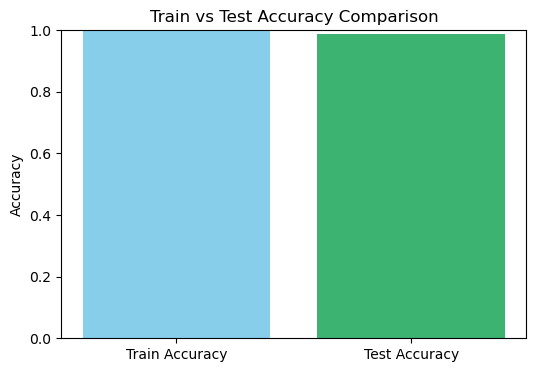

In [6]:
#Model building and training 
#Random classifier model
#Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    random_state=42,        # Reproducibility
    max_depth=None,         # Let trees grow fully
    n_jobs=-1               # Use all cores for faster training
)

# Train the model
rf_model.fit(X_train, y_train)
print(" Random Forest model training completed successfully!")

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, rf_train_pred)
test_accuracy = accuracy_score(y_test, rf_test_pred)

# Print results
print(f" Random Forest Model Accuracy:")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy : {test_accuracy*100:.2f}%")

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['skyblue', 'mediumseagreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy Comparison')

In [7]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Setup grid search
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid,
                           cv=3,          # 3-fold cross validation
                           n_jobs=-1,     # use all processors
                           verbose=2)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate the tuned model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_rf.predict(X_test)
tuned_acc = accuracy_score(y_test, y_pred)
# Add Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix ")
print(cm)

print(f"\n🔹 Tuned Model Accuracy: {tuned_acc*100:.2f}%")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters Found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Confusion Matrix 
[[  569     0     0    99     0     0     0]
 [    0  1012     0    10     0     0     0]
 [    0     0     0     6     0     0     0]
 [    0     0     0 11026     0     0     0]
 [    0    11     0     0     0     0     0]
 [    0     4     0     0     0     0     0]
 [    0    25     0     0     0     0     0]]

🔹 Tuned Model Accuracy: 98.79%

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       668
           1       0.96      0.99      0.98      1022
           4       0.00      0.00      0.00         6
           5       0.99      1.00      0.99     11026
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         4
           8       0.00 

c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


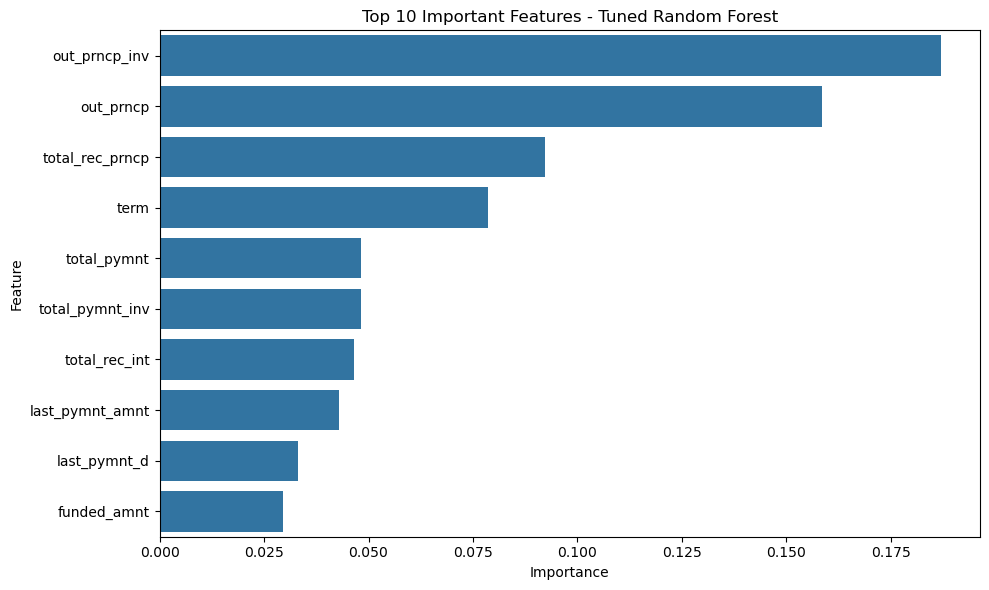

In [8]:
#Feature importance
import pandas as pd
import seaborn as sns

importances = best_rf.feature_importances_
features = X.columns

feature_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10))
plt.title('Top 10 Important Features - Tuned Random Forest')
plt.tight_layout()
plt.show()

In [20]:
import joblib

# Save the final tuned model
joblib.dump(best_rf, 'final_random_forest_model.pkl')



['final_random_forest_model.pkl']

In [17]:
# Example: simulate unseen data
sample_data = X_test.iloc[:5]
preds = best_rf.predict(sample_data)

print("Predictions on new unseen samples:", preds)

Predictions on new unseen samples: [5 0 5 1 5]


In [11]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [21]:
import streamlit as st
import joblib
import numpy as np

# Load the trained Random Forest model
model = joblib.load('final_random_forest_model.pkl')

st.title("Loan Default Prediction System")
st.write("Predict customer loan default risk using behavioral data from Lending Club dataset.")

# Borrower ID (optional)
borrower_id = st.text_input("Borrower ID ")

# Behavioral Inputs
transaction_freq_open = st.number_input("Number of Open Credit Lines", min_value=0, step=1)
total_acc = st.number_input("Total Number of Credit Accounts", min_value=0, step=1)
delinq_2yrs = st.number_input("Delinquencies in Last 2 Years", min_value=0, step=1)
mths_since_last_delinq = st.number_input("Months Since Last Delinquency (0 if none)", min_value=0, step=1)
revol_bal = st.number_input("Revolving Balance ($)", min_value=0.0, step=100.0)
revol_util = st.number_input("Revolving Utilization (%)", min_value=0.0, step=0.1)
inq_last_6mths = st.number_input("Credit Inquiries in Last 6 Months", min_value=0, step=1)

# Financial/Demographic Inputs
annual_inc = st.number_input("Annual Income ($)", min_value=0.0, step=1000.0)
emp_length = st.number_input("Employment Length (years)", min_value=0, step=1)
loan_amnt = st.number_input("Loan Amount ($)", min_value=100.0, step=100.0)
purpose = st.selectbox("Loan Purpose", (["debt_consolidation", "credit_card", "home_improvement", "major_purchase", "small_business", "car", "med" "vacation", "moving", "other"]))

# Convert categorical 'purpose' to numeric if your model expects encoding
# For simplicity, you can one-hot encode manually or use your trained encoder
purpose_mapping = {
    "debt_consolidation": 0, "credit_card": 1, "home_improvement": 2,
    "major_purchase": 3, "small_business": 4, "car": 5,
    "medical": 6, "vacation": 7, "moving": 8, "other": 9
}
purpose_encoded = purpose_mapping[purpose]

# Predict button
if st.button("Predict Default Risk"):
    input_features = np.array([
        transaction_freq_open,
        total_acc,
        delinq_2yrs,
        mths_since_last_delinq,
        revol_bal,
        revol_util,
        inq_last_6mths,
        annual_inc,
        emp_length,
        loan_amnt,
        purpose_encoded
    ]).reshape(1, -1)
    
    prediction = model.predict(input_features)[0]
    risk_mapping = {0: "Not Defaulted", 1: "Defaulted"}
    
    st.success(f"Prediction for Borrower {borrower_id if borrower_id else '(no ID)'}: {risk_mapping[prediction]}")

2025-11-21 12:26:52.641 
  command:

    streamlit run c:\Users\DELL\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-21 12:26:52.647 Session state does not function when running a script without `streamlit run`
